In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

In [3]:
# Load the dataset
data = pd.read_csv('cleaned_data.csv')

# Display the first few rows
data.head()

,DateUtc,VIN,Make,Model,Location,ReportedBy,Company,EmailAddress,Inspection Organisation,Inspection Type,Inspection Organisation External ID,DefectsFound,AIAG,Position,Damage,Severity,Notes
0,2021-07-02 12:51:31,WF02XXERK2MM86910,Ford,Puma,NaN,Niluefer Bahcuvan,NaN,nbahcuva@ford.com,NaN,NaN,NaN,Yes,92-06-5,License Bracket,Cracked - Does not apply to glass,">12"" / > 30cm.",NaN
1,2021-07-02 12:10:38,3FMTK3R71MMA09121,Ford,Mach-E,NaN,Kaitlyn Dubay,NaN,kdubay@ford.com,NaN,NaN,NaN,Yes,28-08-6,Keys,Missing,Missing/Major Damage,Missing
2,2021-07-02 12:10:38,3FMTK3R71MMA09121,Ford,Mach-E,NaN,Kaitlyn Dubay,NaN,kdubay@ford.com,NaN,NaN,NaN,Yes,22-12-2,Grille,Scratched - Does not apply to glass,"From 1"" - 3"" / 2.5cm - 7.5cm.",NaN
3,2021-07-01 11:48:19,5LMCJ1D92LUL01934,Lincoln,Corsair,NaN,Ford,NaN,d.start+ford@degould.com,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
4,2021-07-01 11:43:46,5LMCJ1D92LUL01934,Lincoln,Corsair,NaN,Ford,NaN,d.start+ford@degould.com,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1474918 entries, 0 to 1474917
Data columns (total 17 columns):
 #   Column                               Non-Null Count    Dtype 
---  ------                               --------------    ----- 
 0   DateUtc                              1474918 non-null  object
 1   VIN                                  1474918 non-null  object
 2   Make                                 1474889 non-null  object
 3   Model                                1474889 non-null  object
 4   Location                             1467588 non-null  object
 5   ReportedBy                           1474918 non-null  object
 6   Company                              1473554 non-null  object
 7   EmailAddress                         1474918 non-null  object
 8   Inspection Organisation              1473554 non-null  object
 9   Inspection Type                      1473554 non-null  object
 10  Inspection Organisation External ID  1279449 non-null  object
 11  DefectsFoun

In [5]:
data.isnull().sum() #counts how many missing values are there in each row

DateUtc                                      0
VIN                                          0
Make                                        29
Model                                       29
Location                                  7330
ReportedBy                                   0
Company                                   1364
EmailAddress                                 0
Inspection Organisation                   1364
Inspection Type                           1364
Inspection Organisation External ID     195469
DefectsFound                                 0
AIAG                                   1277393
Position                               1277393
Damage                                 1277393
Severity                               1277393
Notes                                  1430973
dtype: int64

In [6]:
# Remove rows where EITHER Make or Model is null
data = data.dropna(subset=['Make', 'Model'])

In [8]:
# Keep only rows where Damage Found is 'Yes'
data = data[data['DefectsFound'] == 'Yes']

In [9]:
# Extracting year from DateUtc
data['Year'] = pd.to_datetime(data['DateUtc']).dt.year
data['Month'] = pd.to_datetime(data['DateUtc']).dt.month

In [10]:
data.shape

(197525, 19)

In [11]:
# Group damage counts by Model and Year
model_yearly_damage = data.groupby(['Make', 'Model', 'Year'])['Damage'].count().reset_index()
model_yearly_damage = model_yearly_damage.rename(columns={'Damage': 'Damage_Count'})


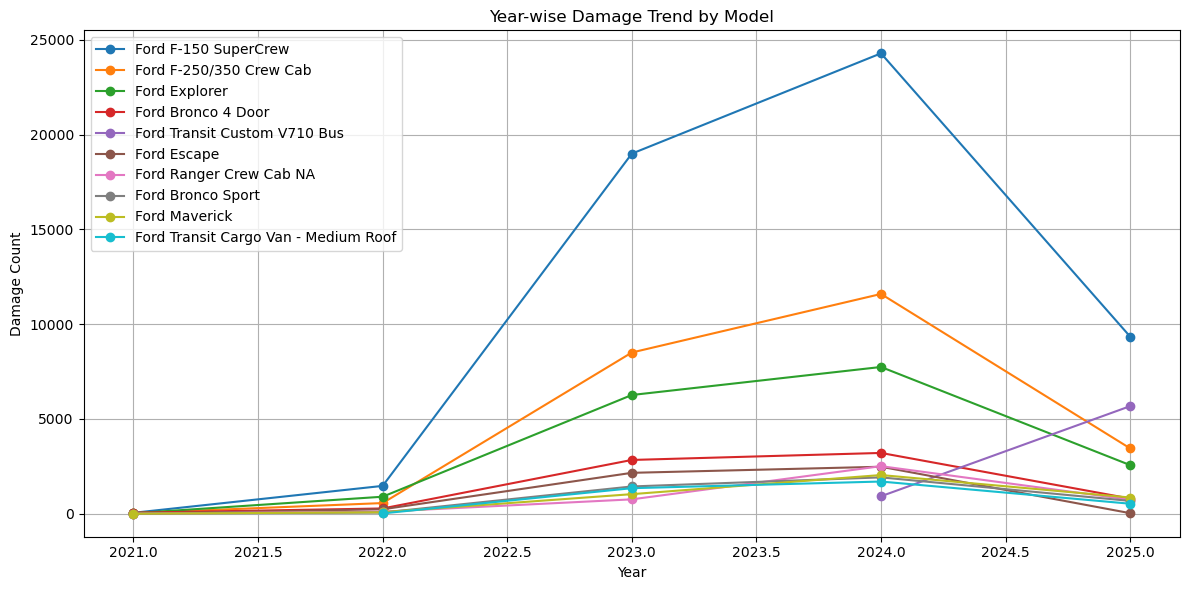

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sample_models = model_yearly_damage.groupby(['Make', 'Model'])['Damage_Count'].sum().sort_values(ascending=False).head(10).index.tolist()

plt.figure(figsize=(12, 6))
for make_model in sample_models:
    make, model = make_model
    model_data = model_yearly_damage[(model_yearly_damage['Make'] == make) & (model_yearly_damage['Model'] == model)]
    plt.plot(model_data['Year'], model_data['Damage_Count'], marker='o', label=f'{make} {model}')

plt.title('Year-wise Damage Trend by Model')
plt.xlabel('Year')
plt.ylabel('Damage Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
model_yearly_damage.to_csv('model_yearly_damage.csv', index=False)

In [13]:
# Get last two years in dataset
recent_years = sorted(data['Year'].unique())[-2:]

# Pivot table: rows=model, columns=year, values=damage count
pivot = model_yearly_damage.pivot_table(index=['Make', 'Model'], columns='Year', values='Damage_Count', fill_value=0)

# Filter only models with damage increase from year1 to year2
pivot['Increase'] = pivot[recent_years[1]] - pivot[recent_years[0]]
rising_models = pivot[pivot['Increase'] > 0].sort_values(by='Increase', ascending=False)

rising_models


Year                                  2021  2022  2023   2024    2025  \
Make Model                                                              
Ford Transit Custom V710 Bus           0.0   0.0   0.0  923.0  5676.0   
     J74 V710                          0.0   0.0   0.0    0.0     9.0   
     Mach-E EU                         0.0  10.0   4.0    2.0    11.0   
     Capri                             0.0   0.0   0.0   28.0    35.0   
     Transit Cargo Van - Low Roof EU   0.0   0.0   1.0    0.0     3.0   
     Mach-E GT EU                      0.0   0.0   0.0    0.0     1.0   

Year                                  Increase  
Make Model                                      
Ford Transit Custom V710 Bus            4753.0  
     J74 V710                              9.0  
     Mach-E EU                             9.0  
     Capri                                 7.0  
     Transit Cargo Van - Low Roof EU       3.0  
     Mach-E GT EU                          1.0

In [19]:
# Convert DateUtc to datetime and extract year-month
data['DateUtc'] = pd.to_datetime(data['DateUtc'])
data['YearMonth'] = data['DateUtc'].dt.to_period('M')

# Aggregate damage counts per Model per month
monthly_damage = data.groupby(['Model', 'YearMonth']).size().reset_index(name='Damage_Count')

# Convert YearMonth back to datetime (first day of month)
monthly_damage['YearMonth'] = monthly_damage['YearMonth'].dt.to_timestamp()



In [20]:
# Get all months in dataset
all_months = pd.date_range(start=monthly_damage['YearMonth'].min(), end=monthly_damage['YearMonth'].max(), freq='MS')

# For each model, create a complete monthly index and fill missing months with 0 damage
models = monthly_damage['Model'].unique()
ts_data = []

for model in models:
    model_ts = monthly_damage[monthly_damage['Model'] == model].set_index('YearMonth').reindex(all_months, fill_value=0)
    model_ts['Model'] = model
    model_ts = model_ts.reset_index().rename(columns={'index': 'YearMonth'})
    ts_data.append(model_ts)

ts_data = pd.concat(ts_data)


In [24]:
from statsmodels.tsa.arima.model import ARIMA

# Select one model for demonstration
model_name = 'Transit Custom V710 Bus'  

model_data = ts_data[ts_data['Model'] == model_name].set_index('YearMonth')['Damage_Count']

# Train ARIMA (p,d,q) — you may need to tune these parameters or use auto_arima from pmdarima
arima_model = ARIMA(model_data, order=(1,1,1))
arima_result = arima_model.fit()

# Forecast next 7 months (Jun-Dec 2025)
forecast = arima_result.forecast(steps=7).round().astype(int)

print(f"Forecasted damage counts for {model_name} for next 7 months:")
print(forecast)


C:\Users\chint\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\chint\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\chint\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecasted damage counts for Transit Custom V710 Bus for next 7 months:
2025-06-01    661
2025-07-01    689
2025-08-01    692
2025-09-01    692
2025-10-01    692
2025-11-01    692
2025-12-01    692
Freq: MS, Name: predicted_mean, dtype: int32


In [25]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np

def forecast_model_damage(model_name, model_df, steps=7):
    """
    Fit ARIMA model and forecast damage counts for given model time series.
    
    Args:
        model_name (str): model name
        model_df (pd.DataFrame): DataFrame with columns ['YearMonth', 'Damage_Count']
        steps (int): Number of months to forecast
        
    Returns:
        pd.DataFrame: forecasted damage counts with columns ['Model', 'YearMonth', 'Damage_Count']
    """
    ts = model_df.set_index('YearMonth')['Damage_Count']
    
    # Fit ARIMA — you can customize order or use auto_arima
    try:
        arima_model = ARIMA(ts, order=(1,1,1))
        arima_result = arima_model.fit()
        
        forecast = arima_result.forecast(steps=steps)
        forecast = forecast.round().astype(int)  # Convert to int
        
        # Create DataFrame for forecast results
        future_months = pd.date_range(start=ts.index[-1] + pd.offsets.MonthBegin(1), periods=steps, freq='MS')
        forecast_df = pd.DataFrame({
            'Model': model_name,
            'YearMonth': future_months,
            'Damage_Count': forecast.values
        })
        
        return forecast_df
    except Exception as e:
        print(f"Error forecasting model {model_name}: {e}")
        return pd.DataFrame()  # Return empty if error


In [26]:
all_forecasts = []

for model in ts_data['Model'].unique():
    model_df = ts_data[ts_data['Model'] == model][['YearMonth', 'Damage_Count']]
    forecast_df = forecast_model_damage(model, model_df, steps=7)
    if not forecast_df.empty:
        all_forecasts.append(forecast_df)

# Concatenate all model forecasts into one DataFrame
final_forecast = pd.concat(all_forecasts, ignore_index=True)


C:\Users\chint\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\chint\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\chint\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\chint\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\chint\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

In [27]:
final_forecast.to_csv('model_damage_forecast.csv', index=False)
print("Forecast saved to model_damage_forecast.csv")


Forecast saved to model_damage_forecast.csv


In [28]:
def forecast_total_damage(model_name, model_df, steps=7):
    ts = model_df.set_index('YearMonth')['Damage_Count']
    try:
        arima_model = ARIMA(ts, order=(1,1,1))
        arima_result = arima_model.fit()
        
        forecast = arima_result.forecast(steps=steps)
        total_damage = int(round(forecast.sum()))
        
        return {'Model': model_name, 'Predicted_Future_Damage': total_damage}
    except Exception as e:
        print(f"Error forecasting model {model_name}: {e}")
        return {'Model': model_name, 'Predicted_Future_Damage': None}

# Loop for all models
results = []
for model in ts_data['Model'].unique():
    model_df = ts_data[ts_data['Model'] == model][['YearMonth', 'Damage_Count']]
    res = forecast_total_damage(model, model_df, steps=7)
    results.append(res)

# Convert to DataFrame
final_predictions = pd.DataFrame(results)

# Save to CSV
final_predictions.to_csv('model_total_future_damage_predictions.csv', index=False)
print("Saved total future damage predictions per Model to CSV")


C:\Users\chint\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\chint\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\chint\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\chint\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\chint\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Saved total future damage predictions per Model to CSV
